In [2]:
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW, get_linear_schedule_with_warmup
from datasets import load_dataset
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm

c:\Users\devan\Desktop\Sem 6\Gen AI\Tutorials\Tutorial 6\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load Wikipedia dataset with trust_remote_code
dataset = load_dataset("wikipedia", "20220301.en") # Add this parameter
train_dataset = dataset['train'].shuffle(seed=42).select(range(10000))
val_dataset = dataset['train'].shuffle(seed=42).select(range(10000, 11000))

In [4]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token  # Set padding token

# Tokenize datasets
def tokenize_function(examples):
    return tokenizer(examples['text'], truncation=True, padding='max_length', max_length=512)

tokenized_train = train_dataset.map(tokenize_function, batched=True, remove_columns=['text'])
tokenized_val = val_dataset.map(tokenize_function, batched=True, remove_columns=['text'])

# Convert to PyTorch Dataset
class GPT2Dataset(Dataset):
    def __init__(self, tokenized_data):
        self.input_ids = tokenized_data['input_ids']
        self.attention_mask = tokenized_data['attention_mask']
    
    def __len__(self):
        return len(self.input_ids)
    
    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.input_ids[idx]),
            'attention_mask': torch.tensor(self.attention_mask[idx]),
            'labels': torch.tensor(self.input_ids[idx])  # Labels for LM
        }

train_pt = GPT2Dataset(tokenized_train)
val_pt = GPT2Dataset(tokenized_val)

In [5]:
batch_size = 4  # Adjust based on GPU
train_loader = DataLoader(train_pt, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_pt, batch_size=batch_size)

In [6]:
model = GPT2LMHeadModel.from_pretrained('gpt2').to(device)

In [7]:
model.eval()
total_loss = 0
with torch.no_grad():
    for batch in val_loader:
        inputs = batch['input_ids'].to(device)
        masks = batch['attention_mask'].to(device)
        outputs = model(inputs, attention_mask=masks, labels=inputs)
        total_loss += outputs.loss.item()
avg_loss = total_loss / len(val_loader)
print(f"Pre-trained Model Perplexity: {np.exp(avg_loss):.2f}")

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Pre-trained Model Perplexity: 366.94


In [8]:
optimizer = AdamW(model.parameters(), lr=5e-5)
epochs = 3
total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0.1*total_steps, num_training_steps=total_steps)

c:\Users\devan\Desktop\Sem 6\Gen AI\Tutorials\Tutorial 6\.venv\Lib\site-packages\transformers\optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [9]:
train_losses, val_losses = [], []

for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        inputs = batch['input_ids'].to(device)
        masks = batch['attention_mask'].to(device)
        outputs = model(inputs, attention_mask=masks, labels=inputs)
        loss = outputs.loss
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
    
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            inputs = batch['input_ids'].to(device)
            masks = batch['attention_mask'].to(device)
            outputs = model(inputs, attention_mask=masks, labels=inputs)
            total_val_loss += outputs.loss.item()
    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    print(f"Epoch {epoch+1}: Train Loss={avg_train_loss:.3f}, Val Loss={avg_val_loss:.3f}")

100%|██████████| 2500/2500 [58:32<00:00,  1.40s/it] 


Epoch 1: Train Loss=2.007, Val Loss=1.865


100%|██████████| 2500/2500 [58:00<00:00,  1.39s/it]


Epoch 2: Train Loss=1.801, Val Loss=1.846


100%|██████████| 2500/2500 [53:20<00:00,  1.28s/it]


Epoch 3: Train Loss=1.735, Val Loss=1.842


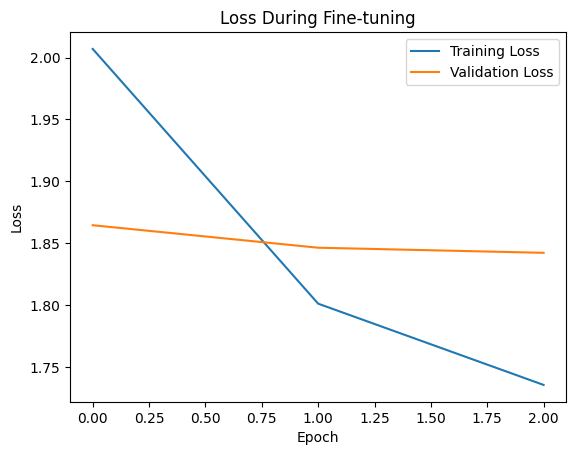

In [10]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss During Fine-tuning')
plt.show()

In [11]:
model.eval()
total_loss = 0
with torch.no_grad():
    for batch in val_loader:
        inputs = batch['input_ids'].to(device)
        masks = batch['attention_mask'].to(device)
        outputs = model(inputs, attention_mask=masks, labels=inputs)
        total_loss += outputs.loss.item()
avg_loss = total_loss / len(val_loader)
print(f"Fine-tuned Model Perplexity: {np.exp(avg_loss):.2f}")

Fine-tuned Model Perplexity: 6.31


In [13]:
# Save entire model (architecture + weights)
model.save_pretrained("./fine_tuned_gpt2_wiki")

# Save tokenizer (required for future usage)
tokenizer.save_pretrained("./fine_tuned_gpt2_wiki")

('./fine_tuned_gpt2_wiki\\tokenizer_config.json',
 './fine_tuned_gpt2_wiki\\special_tokens_map.json',
 './fine_tuned_gpt2_wiki\\vocab.json',
 './fine_tuned_gpt2_wiki\\merges.txt',
 './fine_tuned_gpt2_wiki\\added_tokens.json')

In [12]:
def generate_text(model, tokenizer, prompt, max_length=50):
    inputs = tokenizer.encode(prompt, return_tensors='pt').to(device)
    outputs = model.generate(inputs, max_length=max_length, do_sample=True, temperature=0.7)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# Pre-trained model
pre_model = GPT2LMHeadModel.from_pretrained('gpt2').to(device)
print("Before Fine-tuning:")
print(generate_text(pre_model, tokenizer, "Artificial intelligence (AI) is"))

# Fine-tuned model
print("\nAfter Fine-tuning:")
print(generate_text(model, tokenizer, "Artificial intelligence (AI) is"))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Before Fine-tuning:


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Artificial intelligence (AI) is often seen as a means to advance human capabilities. It has been described as "the next big thing" in the field of digital intelligence. In one paper, Dr. Paul Gilman, the director of the Center

After Fine-tuning:
Artificial intelligence (AI) is a field of research, aimed at improving the human understanding of the world through the study of artificial intelligence. Most of this work focuses on artificial intelligence research and simulation. Artificial intelligence is also used to address a wide range


In [14]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# Load from directory
model = GPT2LMHeadModel.from_pretrained("./fine_tuned_gpt2_wiki").to(device)
tokenizer = GPT2Tokenizer.from_pretrained("./fine_tuned_gpt2_wiki")

# Generate text
prompt = "The theory of relativity states that"
inputs = tokenizer.encode(prompt, return_tensors="pt").to(device)
outputs = model.generate(inputs, max_length=100, do_sample=True)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The theory of relativity states that the time of arrival or departure of some particles of space is known. Since they do not have direct collision with each other, it is assumed they each travel back to a starting point independently of the origin (say, before the event).

When time travel is concerned, particles are not separated by the particle time. However, some particles travel back first in the same direction, thus leaving the time zone with that direction. These particles may travel farther than the origin,
